# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset (not a subset of words or reviews), in this assignment we return to using GraphLab Create for its efficiency. As usual, let's start by **firing up GraphLab Create**.

Make sure you have the latest version of GraphLab Create (1.8.3 or later). If you don't find the decision tree module, then you would need to upgrade graphlab-create using

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

## Fire up Scikit-learn, Pandas and Numpy

In [1305]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

# Load amazon review dataset

In [1306]:
products = pd.read_csv('amazon_baby.csv')

# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [1307]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [1308]:
# Turn nan to nothing. Turning nan to nothing before removing punctuation is critical
products = products.fillna({'review':''})

In [1309]:
# Remove punctuation
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator) 
products['review_clean'] = products['review'].astype(str).apply(remove_punctuation) #astype(str) makes sure all reviews are strings'

In [1310]:
products.head()

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [1311]:
# Remove reviews with "neutral" sentiment (rating 3).
products = products[products['rating'] != 3]

In [1312]:
# Positive sentiment to +1 and negative sentiment to -1
# Now, we will assign reviews with a rating of 4 or higher to be positive reviews, 
# while the ones with rating of 2 or lower are negative. For the sentiment column, 
# we use +1 for the positive class label and -1 for the negative class label. 
# A good way is to create an anonymous function that converts a rating into a class label and 
# then apply that function to every element in the rating column. 
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [1313]:
products.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


Now, we can see that the dataset contains an extra column called sentiment which is either positive (+1) or negative (-1).

# Split into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. If you are using SFrame, make sure to use seed=1 so that you get the same result as everyone else does. (This way, you will get the right numbers for the quiz.) If you are other tools, consult appropriate manuals to perform a train/test split.

In [1314]:
traindata = pd.read_json('module-9-assignment-train-idx.json')[0]
testdata = pd.read_json('module-9-assignment-test-idx.json')[0]

In [1315]:
products

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1
6,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",4,Lovely book its bound tightly so you may not b...,1
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5,Perfect for new parents We were able to keep t...,1
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5,A friend of mine pinned this product on Pinter...,1
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1


In [1316]:
#pull train and test data from products data using the index docs
train_data = products.iloc[traindata]
test_data = products.iloc[testdata]

In [1317]:
print(len(train_data))
print(len(test_data))

133416
33336


In [1318]:
train_data

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1
6,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",4,Lovely book its bound tightly so you may not b...,1
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5,Perfect for new parents We were able to keep t...,1
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5,A friend of mine pinned this product on Pinter...,1
11,"Baby Tracker&reg; - Daily Childcare Journal, S...",This book is perfect! I'm a first time new mo...,5,This book is perfect Im a first time new mom ...,1
12,"Baby Tracker&reg; - Daily Childcare Journal, S...",I originally just gave the nanny a pad of pape...,4,I originally just gave the nanny a pad of pape...,1


In [1319]:
train_data['sentiment'].isnull().sum()

0

# Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
Compute the occurrences of the words in each review and collect them into a row vector.
Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix.
Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.
The following cell uses CountVectorizer in scikit-learn. Notice the token_pattern argument in the constructor.

In [1320]:
train_data['review_clean'].head()

1    it came early and was not disappointed i love ...
2    Very soft and comfortable and warmer than it l...
3    This is a product well worth the purchase  I h...
4    All of my kids have cried nonstop when I tried...
5    When the Binky Fairy came to our house we didn...
Name: review_clean, dtype: object

In [1321]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [1322]:
print(train_matrix.shape)
print(test_matrix.shape)

(133416, 121712)
(33336, 121712)


In [1323]:
train_data

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1
6,A Tale of Baby's Days with Peter Rabbit,"Lovely book, it's bound tightly so you may not...",4,Lovely book its bound tightly so you may not b...,1
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5,Perfect for new parents We were able to keep t...,1
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5,A friend of mine pinned this product on Pinter...,1
11,"Baby Tracker&reg; - Daily Childcare Journal, S...",This book is perfect! I'm a first time new mo...,5,This book is perfect Im a first time new mom ...,1
12,"Baby Tracker&reg; - Daily Childcare Journal, S...",I originally just gave the nanny a pad of pape...,4,I originally just gave the nanny a pad of pape...,1


# Train a sentiment classifier with logistic regression

Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the LogisticRegression class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (train_matrix) as features and the column sentiment of train_data as the target. Use the default values for other parameters. Call this model model.

In [1324]:
np.isnan(train_data['sentiment']).head()

1    False
2    False
3    False
4    False
5    False
Name: sentiment, dtype: bool

In [1325]:
train_data.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [1326]:
#Step 1. Import the model I want to use
from sklearn.linear_model import LogisticRegression

#Step 2. Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
#logisticRegr2 = linear_model.LogisticRegression()

#Step 3. Training the model on the data, storing the information learned from the data
model = logisticRegr.fit(train_matrix, train_data['sentiment'])

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

Compute the accuracy on the test set using your tool of choice. If you are using scikit-learn, you can use the pre-defined method accuracy_score:

In [1327]:
import pandas
print(pandas.__version__)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].values, y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

0.23.4
Test Accuracy: 0.932265418766


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [1328]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


** Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?

In [1329]:
print('answer: yes')

answer: yes


## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [1330]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].values,
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   805
      1       |        1        | 27290


IMPORTANT. In one way or another, make sure to print out the predicted label and the true label for each and every entry of the confusion matrix. This way, we don't mistake one type of mistake for another. The cell above produces the following output:

target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3787
     -1       |        1        |  1454
      1       |       -1        |   805
      1       |        1        | 27290

Quiz Question: How many predicted values in the test set are false positives?

In [1331]:
print('answer: 1454')

answer: 1454


## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [1332]:
print ('answer',1454*100+805*1)

answer 146205


## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

First, let us compute the precision of the logistic regression classifier on the test_data. Scikit-learn provides a predefined method for computing precision. (Consult appropriate manuals if you are using other tools.)

In [1333]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].values, 
                            y_pred=model.predict(test_matrix))
print ("Precision on test data: %s" % precision)

Precision on test data: 0.949448561389


Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

In [1334]:
print('answer:',1-0.949448561389)

answer: 0.05055143861099998


**Quiz Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see the quiz)

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [1335]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.971347214807


**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?



In [1336]:
print('answer',0.971347214807)

answer 0.971347214807


**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

In [1337]:
print('answer',0.971347214807)

answer 0.971347214807


# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  



## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [1338]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    elements=[]
    for p in probabilities:
        if p>=threshold:
            elements.append(+1)
        else:
            elements.append(-1)
    return np.array(elements)

        

In [1339]:
apply_threshold([0.7], 0.7)

array([1])

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.m

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.




In [1340]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [1341]:
probabilities

array([ 0.78107798,  0.99999929,  0.93412345, ...,  0.99999448,
        0.99999741,  0.98089635])

In [1342]:
predictions_with_default_threshold =apply_threshold(probabilities, 0.5)

In [1343]:
predictions_with_default_threshold

array([1, 1, 1, ..., 1, 1, 1])

In [1344]:
predictions_with_high_threshold=apply_threshold(probabilities, 0.9)

In [1345]:
print ('Number of positive predicted reviews (threshold = 0.5)',(predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5) 28743


In [1346]:
recall_default = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=predictions_with_default_threshold)
recall_default

0.97134721480690511

In [1347]:
print ("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 25070


In [1348]:
recall_high = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=predictions_with_high_threshold)
recall_high

0.87592098238120664

Quiz question: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

In [1349]:
print('answer: the number of positive predicted reviews decreased')

answer: the number of positive predicted reviews decreased


## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1. In Python, we run



In [1350]:
threshold_values = np.linspace(0.5, 1, num=100)
print (threshold_values)

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [1351]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
print(probabilities)
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_data['sentiment'].values, y_pred=predictions)
    recall = recall_score(y_true=test_data['sentiment'].values, y_pred=predictions)
    precision_all.append(precision)
    recall_all.append(recall)

[ 0.78107798  0.99999929  0.93412345 ...,  0.99999448  0.99999741
  0.98089635]


In [1352]:
threshold_values

array([ 0.5       ,  0.50505051,  0.51010101,  0.51515152,  0.52020202,
        0.52525253,  0.53030303,  0.53535354,  0.54040404,  0.54545455,
        0.55050505,  0.55555556,  0.56060606,  0.56565657,  0.57070707,
        0.57575758,  0.58080808,  0.58585859,  0.59090909,  0.5959596 ,
        0.6010101 ,  0.60606061,  0.61111111,  0.61616162,  0.62121212,
        0.62626263,  0.63131313,  0.63636364,  0.64141414,  0.64646465,
        0.65151515,  0.65656566,  0.66161616,  0.66666667,  0.67171717,
        0.67676768,  0.68181818,  0.68686869,  0.69191919,  0.6969697 ,
        0.7020202 ,  0.70707071,  0.71212121,  0.71717172,  0.72222222,
        0.72727273,  0.73232323,  0.73737374,  0.74242424,  0.74747475,
        0.75252525,  0.75757576,  0.76262626,  0.76767677,  0.77272727,
        0.77777778,  0.78282828,  0.78787879,  0.79292929,  0.7979798 ,
        0.8030303 ,  0.80808081,  0.81313131,  0.81818182,  0.82323232,
        0.82828283,  0.83333333,  0.83838384,  0.84343434,  0.84

In [1353]:
import pandas as pd
import numpy as np
dataset = pd.DataFrame({'threshold_values': threshold_values, 'precision_all': precision_all,'recall_all': precision_all}, columns=['threshold_values', 'precision_all','recall_all'])

In [1354]:
dataset

,threshold_values,precision_all,recall_all
0,0.500000,0.949449,0.949449
1,0.505051,0.949923,0.949923
2,0.510101,0.950401,0.950401
3,0.515152,0.950912,0.950912
4,0.520202,0.951334,0.951334
5,0.525253,0.951779,0.951779
6,0.530303,0.952026,0.952026
7,0.535354,0.952276,0.952276
8,0.540404,0.952890,0.952890
9,0.545455,0.953209,0.953209


Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold. Implement the function plot_pr_curve that generates a connected scatter plot from the lists of precision and recall scores. The function would be implemented in matplotlib as follows; for other tools, consult appropriate manuals.

In [1355]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

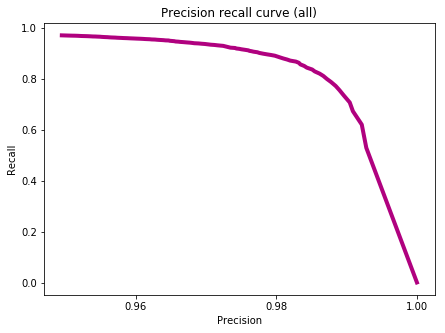

In [1356]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [1357]:
smallest = dataset[(dataset['precision_all'] >= 0.965)]['threshold_values'].min()
smallest

0.70707070707070707

In [1358]:
print('answer',0.707)

answer 0.707


**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [1373]:
probabilities = model.predict_proba(test_matrix)[:,1]
threshold_pred=apply_threshold(probabilities,0.98)
(threshold_pred==-1).sum()

13296

In [1374]:
(test_data['sentiment']==1).sum()

28095

In [1390]:
np.sum((pd.Series(threshold_pred==-1))&(test_data['sentiment']==1))

1983

In [1380]:
np.sum((threshold_pred==-1)&(test_data['sentiment']==1))

8246

In [1392]:
(threshold_pred==-1)

array([ True, False,  True, ..., False, False, False], dtype=bool)

In [1362]:
cmat = confusion_matrix(y_true=test_data['sentiment'].values,
                        y_pred=threshold_pred,
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5050
     -1       |        1        |   191
      1       |       -1        |  8246
      1       |        1        | 19849


# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [1363]:
baby_reviews = test_data[test_data['name'].astype(str).apply(lambda x: 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values. In scikit-learn, this task would be implemented as follows:

In [1364]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [1365]:
baby_matrix

<6611x121712 sparse matrix of type '<class 'numpy.int64'>'
	with 368654 stored elements in Compressed Sparse Row format>

Let's plot the precision-recall curve for the baby_reviews dataset. We again use 100 equally spaced values between 0.5 and 1 for the threshold.

In [1366]:
threshold_values = np.linspace(0.5, 1, num=100)

For each of the values of threshold, we first obtain class predictions for baby_reviews using that threshold. Then we compute the precision and recall scores for baby_reviews. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.



In [1367]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(baby_matrix)[:,1]
for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision.
    # YOUR CODE HERE
    precision = precision_score(y_true=baby_reviews['sentiment'].values, y_pred=predictions)
    
    # YOUR CODE HERE
    recall = recall_score(y_true=baby_reviews['sentiment'].values, y_pred=predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.

In [1368]:
dataset_baby = pd.DataFrame({'threshold_values': threshold_values, 'precision_all': precision_all,'recall_all': precision_all}, columns=['threshold_values', 'precision_all','recall_all'])

In [1369]:
dataset_baby

,threshold_values,precision_all,recall_all
0,0.500000,0.946470,0.946470
1,0.505051,0.946956,0.946956
2,0.510101,0.947443,0.947443
3,0.515152,0.948260,0.948260
4,0.520202,0.948759,0.948759
5,0.525253,0.949259,0.949259
6,0.530303,0.949571,0.949571
7,0.535354,0.949723,0.949723
8,0.540404,0.950376,0.950376
9,0.545455,0.951211,0.951211


In [1370]:
smallest_baby = dataset_baby[(dataset_baby['precision_all'] >= 0.965)]['threshold_values'].min()
smallest_baby

0.72727272727272729

Quiz Question: Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

In [1371]:
print('answer: larger')

answer: larger


Plot the precision-recall curve for baby_reviews only by running

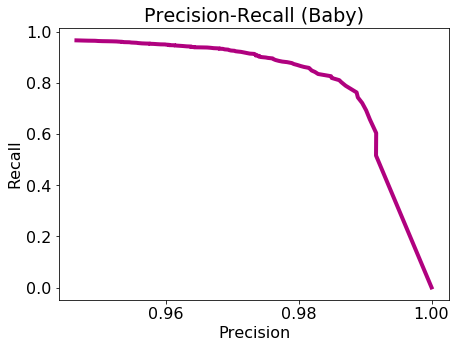

In [1372]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")